## Group Member: Jeffery Zhang, Oliver Liu, Zhe Zhou

In [1]:
import pandas as pd
import numpy as np
import matplotlib as plt
import matplotlib.pyplot as pyplt
import seaborn as sns
import datetime
import calendar
import statistics

### EDA

* #### Some of the columns contain lists and dictionaries. Extract information you need and reformat them. -- Zhe Zhou

In [2]:
# Read the data from the file, and create a DataFrame object.
raw_data_movies = pd.read_csv("tmdb_5000_movies.csv")

In [3]:
# Reformat the columns contain dictionaries as a string list.
raw_data_movies["genres"] = raw_data_movies["genres"].apply(lambda x : [i["name"] for i in eval(x)])
raw_data_movies["keywords"] = raw_data_movies["keywords"].apply(lambda x : [i["name"] for i in eval(x)])
raw_data_movies["production_companies"] = raw_data_movies["production_companies"].apply(lambda x : [i["name"] for i in eval(x)])
raw_data_movies["production_countries"] = raw_data_movies["production_countries"].apply(lambda x : [i["name"] for i in eval(x)])
raw_data_movies["spoken_languages"] = raw_data_movies["spoken_languages"].apply(lambda x : [i["name"] for i in eval(x)])

In [4]:
# Read the data from the file, and create a DataFrame object.
raw_data_credits = pd.read_csv("tmdb_5000_credits.csv")

In [5]:
# Reformat the columns contain dictionaries as a string list.
raw_data_credits["cast"] = raw_data_credits["cast"].apply(lambda x : [i["name"] for i in eval(x)])
raw_data_credits["crew"] = raw_data_credits["crew"].apply(lambda x : [i["job"] + " : " + i["name"] for i in eval(x)])

In [6]:
# Merge two datasets base on the movies' id number, and drop the duplicated columns.
raw_data = pd.merge(raw_data_movies, raw_data_credits.drop("title", 1), left_on = "id", right_on = "movie_id").drop("movie_id", 1)

* #### Clean the dataset, remove the outliers, before any data analysis. Explain what you did. -- Zhe Zhou

In [7]:
# Clean the dataset, and remove the outliers.
data = raw_data[(raw_data["budget"] > 0) &
                (raw_data["original_title"] is not np.nan) &
                (raw_data["popularity"] > 0) & 
                (raw_data["production_companies"].apply(len) != 0) &
                (raw_data["production_countries"].apply(len) != 0) & 
                (raw_data["release_date"] is not np.nan) &
                (raw_data["revenue"] > 0) &
                (raw_data["runtime"] > 0) &
                (raw_data["cast"].apply(len) != 0) & 
                (raw_data["crew"].apply(len) != 0)]

In the process of cleaning the data, the outliers that are caused by artifacts have to be removed. The purpose of this project is to build the model of predicting the revenue of movies, so the values of budget and revenue are not supposed to be zero. Also, the runtime of the movies cannot be zero because it does not make sense. In addition, the columns, "original_title", "cast", and "crew", are necessary since they demonstrate the convincingness of the data. Furthermore, in the other columns, "production_companies" and "production_countries", all these data are required in the model that we are going to build. And now, we are able to begin our data analysis.

In [8]:
data.describe()

,budget,id,popularity,revenue,runtime,vote_average,vote_count
count,3.183000e+03,3183.000000,3183.000000,3.183000e+03,3183.000000,3183.000000,3183.000000
mean,4.113039e+07,44878.875589,29.415936,1.229086e+08,110.859881,6.315112,991.026076
std,4.450600e+07,75046.011568,36.283411,1.871212e+08,20.991509,0.868237,1419.826830
min,1.000000e+00,5.000000,0.037073,5.000000e+00,41.000000,0.000000,0.000000
25%,1.100000e+07,4884.500000,10.812450,1.770142e+07,96.000000,5.800000,189.000000
50%,2.600000e+07,11361.000000,20.786616,5.693230e+07,107.000000,6.300000,484.000000
75%,5.500000e+07,45038.500000,37.689512,1.487174e+08,121.000000,6.900000,1161.000000
max,3.800000e+08,417859.000000,875.581305,2.787965e+09,338.000000,8.500000,13752.000000


* #### Count the number of movies released by day of week, month and year, are there any patterns that you observe? -- Oliver Liu

In [9]:
data['release_date']

0       2009-12-10
1       2007-05-19
2       2015-10-26
3       2012-07-16
4       2012-03-07
           ...    
4773    1994-09-13
4788    1972-03-12
4792    1997-11-06
4796    2004-10-08
4798    1992-09-04
Name: release_date, Length: 3183, dtype: object

In [10]:
days = []
for date in data['release_date']:
    day = calendar.day_name[datetime.datetime.strptime(date, '%Y-%m-%d').weekday()]
    days.append(day)
data["release_day_of_week"] = days
data
groupby_day = data.groupby('release_day_of_week').budget.count()
print(groupby_day.sort_values())

release_day_of_week
Sunday        112
Saturday      129
Monday        157
Tuesday       223
Wednesday     593
Thursday      665
Friday       1304
Name: budget, dtype: int64


<ipython-input-10-4c2d22df4d15>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["release_day_of_week"] = days


* #### What are the movie genre trend shifting patterns that you can observe from the dataset? -- Jeffery Zhang

In [11]:
# Gets all genres in the dataset
unique_genre = {genre for l in data["genres"] for genre in l}
unique_genre

{'Action',
 'Adventure',
 'Animation',
 'Comedy',
 'Crime',
 'Documentary',
 'Drama',
 'Family',
 'Fantasy',
 'Foreign',
 'History',
 'Horror',
 'Music',
 'Mystery',
 'Romance',
 'Science Fiction',
 'Thriller',
 'War',
 'Western'}

In [12]:
# Gets the popularity of all genres including repeats different genres
all_info = {}
for ug in unique_genre:
    list = []
    for l in range (0,len(data["popularity"])):
        nextList = data["genres"].get(l)
        if (nextList is not None and ug in nextList):
            list.append(data["popularity"].get(l))
    all_info[ug] = list

In [13]:
# Removes any genre with no popularity
new_all_info = {key:val for key, val in all_info.items() if val}
new_all_info

{'Animation': [48.681969,
  89.186492,
  49.98659,
  59.995418,
  51.692953,
  125.114374,
  66.390712,
  39.744242,
  92.201962,
  36.167578,
  128.655964,
  44.041186,
  203.73459,
  62.341073,
  47.323228,
  67.263269,
  42.986467,
  65.677399,
  44.141021,
  165.125366,
  41.845878,
  29.332905,
  51.247321,
  12.362599,
  22.550135,
  38.73494,
  44.989192,
  35.601665,
  56.747978,
  61.788035,
  100.21391,
  26.074908,
  17.7735,
  44.765377,
  29.91353,
  84.366984,
  84.689648,
  63.473086,
  20.678787,
  89.938296,
  26.548594,
  68.757242,
  42.40024,
  27.990284,
  106.815545,
  64.183321,
  36.65422,
  19.625972,
  32.473628,
  30.475297,
  62.479574,
  46.727941,
  51.113717,
  36.711378,
  37.321848,
  38.924136,
  34.308098,
  23.230851,
  37.054554,
  65.229868,
  85.688789,
  77.817571,
  73.575118,
  46.781182,
  69.457898,
  67.427755,
  51.548589,
  46.200042,
  37.272385,
  56.257411,
  26.61951,
  36.32705,
  55.659988,
  23.473004,
  29.558157,
  36.125715,
  11

In [14]:
all_info = new_all_info
genres = [*all_info]
genres

['Animation',
 'Drama',
 'Crime',
 'Horror',
 'Fantasy',
 'Thriller',
 'Science Fiction',
 'War',
 'Western',
 'Adventure',
 'Music',
 'Documentary',
 'Mystery',
 'History',
 'Romance',
 'Family',
 'Action',
 'Comedy']

In [15]:
# Uses previous dictionary to get medians and means for each genre
medians = {}
means = {}

In [16]:
for g in genres:
    list = all_info.get(g)
    if(list):
        medians[g] = statistics.median(list)
        means[g] = statistics.mean(list)
median_values = [*medians.values()]
mean_values = [*means.values()]
median_val_rounded = [round(num,2) for num in median_values]
mean_val_rounded = [round(num,2) for num in mean_values]
#len(median_val_rounded)
#len(mean_val_rounded)

Text(0.5, 1.0, 'Median Popularities by Genre')

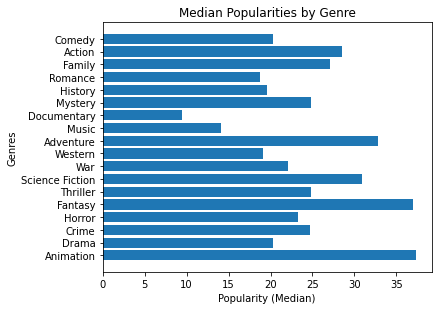

In [17]:
# Plot data
pyplt.barh(y=genres,width=median_val_rounded)
pyplt.tight_layout()
pyplt.xlabel("Popularity (Median)")
pyplt.ylabel("Genres")
pyplt.title("Median Popularities by Genre")

Text(0.5, 1.0, 'Mean Popularities by Genre')

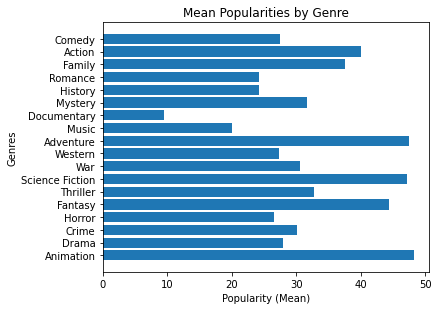

In [18]:
pyplt.barh(y=genres,width=mean_val_rounded)
pyplt.tight_layout()
pyplt.xlabel("Popularity (Mean)")
pyplt.ylabel("Genres")
pyplt.title("Mean Popularities by Genre")

Via my interpretation of the question, "What are the movie genre trend shifting patterns that you can observe from the dataset?", I started by understanding what trends are which are usually the most popular object which means dictates that trend shifting would imply an object in this case our object being movie genre that is farest away from the mean and medians. To get this information, I used the dataset to find all unique genres to find the popularity means and medians for each genre. AfterwardsI used the median and means by genre to visualize the results which displays that documentaries are the movie genre that shifts the movie genre trend pattern the most since it is by far the lowest in both median and mean compared to all other moviegenres.

* #### What are the strongest and weakest features correlated with movie revenue? -- Oliver Liu

In [19]:
data.corr()

,budget,id,popularity,revenue,runtime,vote_average,vote_count
budget,1.000000,0.012717,0.427822,0.703984,0.226795,-0.034135,0.537224
id,0.012717,1.000000,0.178044,0.029373,-0.033730,-0.064647,0.106548
popularity,0.427822,0.178044,1.000000,0.599706,0.179201,0.286779,0.747323
revenue,0.703984,0.029373,0.599706,1.000000,0.231085,0.187030,0.754761
runtime,0.226795,-0.033730,0.179201,0.231085,1.000000,0.382346,0.255873
vote_average,-0.034135,-0.064647,0.286779,0.187030,0.382346,1.000000,0.379500
vote_count,0.537224,0.106548,0.747323,0.754761,0.255873,0.379500,1.000000


<AxesSubplot:>

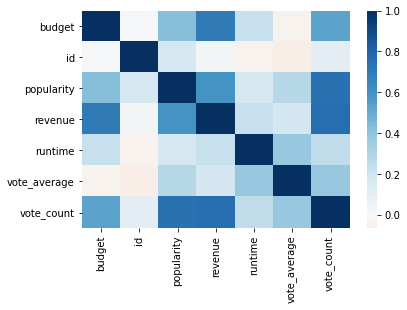

In [20]:
sns.heatmap(data.corr(), cmap='RdBu', center=0)

In [21]:
groupby_day_rev = data.groupby('release_day_of_week').revenue.agg(['count', 'median'])
print(groupby_day_rev.sort_values('median'))

                     count      median
release_day_of_week                   
Saturday               129  41158757.0
Friday                1304  42185535.5
Sunday                 112  44367120.5
Monday                 157  49469904.0
Tuesday                223  68896829.0
Thursday               665  77000000.0
Wednesday              593  86658558.0


By ranking, we see budget is the most correlated with revenue, followed by popularity and vote count.
Runtime is not very strongly correlated with revenue.
Correlation with vote average is suprisingly low.
Correlation with id is, as expected, very low.

### Modeling and Question Answering

In [22]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

* #### Movie Revenue Prediction Model 1 -- Zhe Zhou

/Users/zhezhou/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='budget', ylabel='revenue'>

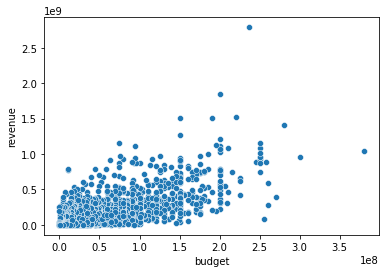

In [23]:
# Create a scatter plot between budget and revenue to find out outliers.
sns.scatterplot(data["budget"], data["revenue"])

In [24]:
# Remove the outliers according to the scatter plot.
data_without_outliers = data[(data["budget"] < 250000000) & (data["revenue"] < 1000000000)]

/Users/zhezhou/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='budget', ylabel='revenue'>

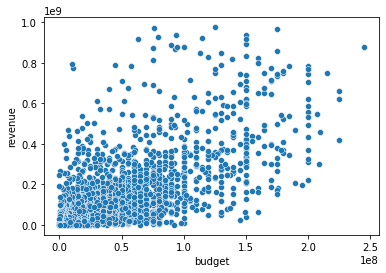

In [25]:
# Create a scatter plot again, and check if there are any outliers else.
sns.scatterplot(data_without_outliers["budget"], data_without_outliers["revenue"])

<h4><center>Build model without the Cross-Validation</center></h4>

In [26]:
# Create a LinearRegression obeject.
model_1 = LinearRegression()
# Create some empty lists to store values.
coef = []
intercept = []
MSE = []
# Create a loop.
times = 0
while (times <= 100):
    # Seperate the dataset to training set and test set.
    train, test = train_test_split(data_without_outliers)
    # Fit the dataset to the model.
    model_1 = model_1.fit(train["budget"].to_numpy().reshape(-1, 1), train["revenue"].to_numpy())
    # Store the value of slope (coefficient) in each loop.
    coef.append(model_1.coef_[0])
    # Store the value of intercept in the model of each loop.
    intercept.append(model_1.intercept_)
    # Calculate predicted values by the values of budget for each movie.
    predictions = model_1.predict(test["budget"].to_numpy().reshape(-1, 1))
    # Store the value of mean square value in the model of each loop.
    MSE.append(np.mean((test["revenue"] - predictions) ** 2))
    times = times + 1
# Use the average of the value of slope (coefficient) as the slope of the fianl model.
model_1.coef_ = np.array([np.mean(coef)])
# Use the average of the value of intercept as the intercept of the fianl model.
model_1.intercept_ = np.mean(intercept)
# Print the final linear regression model.
print("The final linear model is: Revenue = " + str(model_1.coef_[0]) + " * Budget + " + str(model_1.intercept_))

The final linear model is: Revenue = 2.570860890099752 * Budget + 12208157.763377797


In [27]:
# Calculate the average of each linear regression model's MSE in the loop.
MSE_average = np.mean(MSE)
# Print out the average.
print("Average MSE:", MSE_average)

Average MSE: 1.28741010475058e+16


Here we use standard linear regression. With some outliers removed, RMSE comes out to be 113 million USD, a 32 precent improvement from guessing median only.

The equation is roughly  Revenue = 2.571 * Budget + 12 Million USD

Without removing the outliers, we get a RSME 132 million.

In [28]:
# By the model, calculate the predicted values of revenue.
predictions = model_1.predict(data["budget"].to_numpy().reshape(-1, 1))

/Users/zhezhou/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/zhezhou/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='budget', ylabel='revenue'>

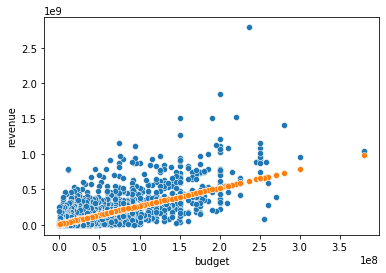

In [29]:
# Create a scatter plot between budget and revenue.
sns.scatterplot(data["budget"], data["revenue"])
# Create a scatter plot between budget and predictions.
sns.scatterplot(data["budget"], predictions)

<h4><center>Build model with the Cross-Validation</center></h4>

In [30]:
# Create a LinearRegression obeject.
model_1 = LinearRegression()
# Create some empty lists to store values.
coef = []
intercept = []
MSE = []
# Create a KFold object to separate the data to the Cross-Validation set.
kf = KFold(n_splits = 10, shuffle = True)
# Create a loop to do the Cross-Validation.
for train_index, test_index in kf.split(data_without_outliers):
    # Get a train set.
    train = data_without_outliers.iloc[train_index]
    # Get a test set.
    test = data_without_outliers.iloc[test_index]
    # Fit the dataset to the model.
    model_1 = model_1.fit(train["budget"].to_numpy().reshape(-1, 1), train["revenue"].to_numpy())
    # Store the value of slope (coefficient) in each loop.
    coef.append(model_1.coef_[0])
    # Store the value of intercept in the model of each loop.
    intercept.append(model_1.intercept_)
    # Calculate predicted values by the values of budget for each movie.
    predictions = model_1.predict(test["budget"].to_numpy().reshape(-1, 1))
    # Store the value of mean square value in the model of each loop.
    MSE.append(np.mean((test["revenue"] - predictions) ** 2))
# Use the average of the value of slope (coefficient) as the slope of the fianl model.
model_1.coef_ = np.array([np.mean(coef)])
# Use the average of the value of intercept as the intercept of the fianl model.
model_1.intercept_ = np.mean(intercept)
# Print the final linear regression model.
print("The final linear model is: Revenue = " + str(model_1.coef_[0]) + " * Budget + " + str(model_1.intercept_))

The final linear model is: Revenue = 2.5711456873224305 * Budget + 12127732.836379379


In [31]:
# Calculate the average of each linear regression model's MSE in the loop.
MSE_average = np.mean(MSE)
# Print out the average.
print("Average MSE:", MSE_average)

Average MSE: 1.2936386832825006e+16


In [32]:
# By the model, calculate the predicted values of revenue.
predictions = model_1.predict(data["budget"].to_numpy().reshape(-1, 1))

/Users/zhezhou/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/zhezhou/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='budget', ylabel='revenue'>

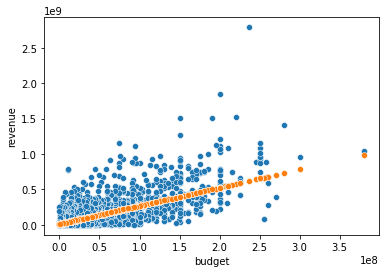

In [33]:
# Create a scatter plot between budget and revenue.
sns.scatterplot(data["budget"], data["revenue"])
# Create a scatter plot between budget and predictions.
sns.scatterplot(data["budget"], predictions)

From the table and heat map, we find the correlation coefficient between budget and revenue is highest. Therefore, we want to build a linear regression model between them. 

Before training the model, we have to separate the dataset into a training set and a test set, and then we need to use the fit function to generate an appropriate linear regression model. But, we find the value of MSE is unsteady and inaccurate each time we generate a linear regression. Since there existing extreme cases which will impact our linear model, we repeat the process of fitting the training set a hundred times and record the value of coefficient (slope) and intercept. And then, we use the mean of coefficient (slope) and intercept as the final model. In order to evaluate the performance of the model, we calculate MSE according to the test set and record value each time we generate the linear regression model. And then, we use the mean as Mean Square Error to the final model.

However, after evaluating the performance of this model, we find that the value of MSE is very large, so it implies that the final model's predictions are not so accurate. But, we wonder if the Cross-Validation can help increase the model's accuracy even though we have applied a similar method. After using the Cross-Validation, we calculate the MSE again. Unfortunately, the MSE doesn't have an obvious decrease.

Therefore, the final model cannot provide accurate predictions, and we think the reason is that we do not apply other features such as genres, production companies to the model. Hence, we guess these variables also play significant roles in movies' revenue.

* #### Movie Revenue Prediction Model 2 -- Oliver Liu

<h4><center>Baseline Model - Guessing the mean of ''training set''</center></h4>
If we do this, then our avg RMSE will be, in essence, the standard deviation of the revenue, which is 187 million USD.
Although out of order, we also calculated the RMSE if we guess the median, which is shown a few lines below, rather than the mean. It was using a somewhat unconventional coding style. The RMSE for median came out to be 165 million USD

<h4><center>Code for RMSE for predicting median</center></h4>

In [34]:
# BASELINE MODEL - MEDIAN
basem1 = LinearRegression()
# Create some empty lists to store values.
coef = []
intercept = []
MSE = []
# Create a loop.
times = 0
while (times <= 100):
    MSE.append(np.mean((test["revenue"] - np.median(data_without_outliers['revenue'])) ** 2))
    times = times + 1
# Use the average of the value of slope (coefficient) as the slope of the fianl model.
basem1.coef_ = 0
# Use the average of the value of intercept as the intercept of the fianl model.
basem1.intercept_ = np.median(data_without_outliers['revenue'])
# Print the final linear regression model.
print("predicting median every time is: Revenue = " + str(np.median(data_without_outliers['revenue'])) )

predicting median every time is: Revenue = 55707411.0


In [35]:
# Calculate the average of each linear regression model's MSE in the loop.
MSE_average = np.mean(MSE)
# Print out the average.
print("Average MSE, for basem1:", MSE_average)
print("Average RMSE:", MSE_average ** 0.5 / 1000000, 'million')

Average MSE, for basem1: 2.350592249648611e+16
Average RMSE: 153.3164130042381 million


/Users/zhezhou/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/zhezhou/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='budget', ylabel='revenue'>

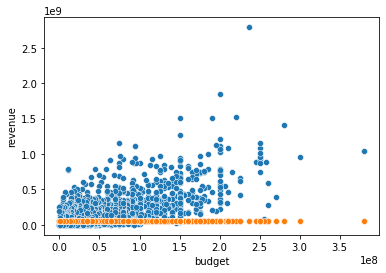

In [36]:
# Create a scatter plot between budget and revenue.
sns.scatterplot(data["budget"], data["revenue"])
# Create a scatter plot between budget and predictions.
sns.scatterplot(data["budget"], np.median(data_without_outliers['revenue']))

<h4><center>Advanced Model - Applying a non-linear function to budget</center></h4>
Here we try training by applying a non-linear function to budget, to see if we can obtain a better model. For simplicity, we have called all the non-linear transformations 'budgetSquared'
We used the original dataset, without removing outliers. First off, is an identity transformation, so same as the standard linear regression, except without removing any outliers. RMSE: 132.77 million USD

After trying several functions, including squared, cubed, square root... The best one came out to be raising budget to the 1.25th power. That resulted in a RMSD of 129 million USD, not a big improvement from 132 million, not enough to pass Occam's Razor's test.

<ipython-input-37-025ba891d088>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["budgetSquared"] = data["budget"]


The final linear model is: Revenue = 2.958617463847757 * BudgetSquared + 1098276.1773424272
Average MSE: 1.773558286227394e+16
Average RMSE: 133.17500839975173 million


/Users/zhezhou/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/zhezhou/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='budget', ylabel='revenue'>

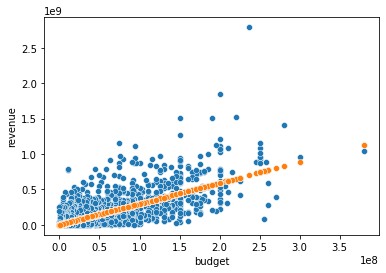

In [37]:
data["budgetSquared"] = data["budget"]
# Create a LinearRegression obeject.
model_2 = LinearRegression()
# Create some empty lists to store values.
coef = []
intercept = []
MSE = []
# Create a loop.
times = 0
while (times <= 100):
    # Seperate the dataset to training set and test set.
    train, test = train_test_split(data)
    # Fit the dataset to the model.
    model_2 = model_2.fit(train["budgetSquared"].to_numpy().reshape(-1, 1), train["revenue"].to_numpy())
    # Store the value of slope (coefficient) in each loop.
    coef.append(model_2.coef_[0])
    # Store the value of intercept in the model of each loop.
    intercept.append(model_2.intercept_)
    # Calculate predicted values by the values of budget for each movie.
    predictions = model_2.predict(test["budgetSquared"].to_numpy().reshape(-1, 1))
    # Store the value of mean square value in the model of each loop.
    MSE.append(np.mean((test["revenue"] - predictions) ** 2))
    times = times + 1
# Use the average of the value of slope (coefficient) as the slope of the fianl model.
model_2.coef_ = np.array([np.mean(coef)])
# Use the average of the value of intercept as the intercept of the fianl model.
model_2.intercept_ = np.mean(intercept)
# # By the model, calculate the predicted values of revenue.
predictions = model_2.predict(data["budgetSquared"].to_numpy().reshape(-1, 1))
# Print the final linear regression model.
print("The final linear model is: Revenue = " + str(model_2.coef_[0]) + " * BudgetSquared + " + str(model_2.intercept_))
# Calculate the average of each linear regression model's MSE in the loop.
MSE_average = np.mean(MSE)
# Print out the average.
print("Average MSE:", MSE_average)
print("Average RMSE:", MSE_average ** 0.5 / 1000000, 'million')
sns.scatterplot(data["budget"], data["revenue"])
sns.scatterplot(data["budget"], predictions)

<ipython-input-38-bd3cf0b8d27f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["budgetSquared"] = data["budget"] ** 1.25


The final linear model is: Revenue = 0.02570989450552221 * BudgetSquared + 25587825.12076948
Average MSE: 1.7526664474005744e+16
Average RMSE: 132.3883094310285 million


/Users/zhezhou/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/zhezhou/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='budget', ylabel='revenue'>

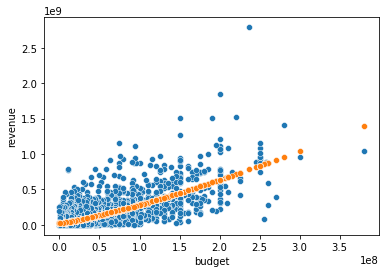

In [38]:
data["budgetSquared"] = data["budget"] ** 1.25
# Create a LinearRegression obeject.
model_2 = LinearRegression()
# Create some empty lists to store values.
coef = []
intercept = []
MSE = []
# Create a loop.
times = 0
while (times <= 100):
    # Seperate the dataset to training set and test set.
    train, test = train_test_split(data)
    # Fit the dataset to the model.
    model_2 = model_2.fit(train["budgetSquared"].to_numpy().reshape(-1, 1), train["revenue"].to_numpy())
    # Store the value of slope (coefficient) in each loop.
    coef.append(model_2.coef_[0])
    # Store the value of intercept in the model of each loop.
    intercept.append(model_2.intercept_)
    # Calculate predicted values by the values of budget for each movie.
    predictions = model_2.predict(test["budgetSquared"].to_numpy().reshape(-1, 1))
    # Store the value of mean square value in the model of each loop.
    MSE.append(np.mean((test["revenue"] - predictions) ** 2))
    times = times + 1
# Use the average of the value of slope (coefficient) as the slope of the fianl model.
model_2.coef_ = np.array([np.mean(coef)])
# Use the average of the value of intercept as the intercept of the fianl model.
model_2.intercept_ = np.mean(intercept)
# By the model, calculate the predicted values of revenue.
predictions = model_2.predict(data["budgetSquared"].to_numpy().reshape(-1, 1))
# Print the final linear regression model.
print("The final linear model is: Revenue = " + str(model_2.coef_[0]) + " * BudgetSquared + " + str(model_2.intercept_))
# Calculate the average of each linear regression model's MSE in the loop.
MSE_average = np.mean(MSE)
# Print out the average.
print("Average MSE:", MSE_average)
print("Average RMSE:", MSE_average ** 0.5 / 1000000, 'million')
sns.scatterplot(data["budget"], data["revenue"])
sns.scatterplot(data["budget"], predictions)

<h4><center>Advanced model - classifying by budget, then applying linear regression</center></h4>
We created three budget classes, under 15 million USD, 15 million - 105 million USD, and Over 105 million USD, as data1, data2, data3, respectively.
We then applied standard linear regression to those three classes, and compared it to the original model 1.
As it turned out, model 1 was nearly identical to what data1 and data2 training separately, but for model 3,  Model 1 RMSE: 312 million, where training on data3 alone 292 million, so that gave a 6.4 percent improvement, perhaps still not enough to pass Occam's Razor Test.

In [39]:
data1 = data[(data["budget"] < 15000000)]
data2 = data[(data["budget"] > 15000000) & (data["budget"] < 105000000)]
data3 = data[(data["budget"] > 105000000)]
# data4 = data[(data["budget"] > 200000000)]
# data1.describe()
#data2.describe()
# data3.describe()
# data4.describe()
# pyplt.hist(data1.budget, bins=10)
# pyplt.hist(data2.budget, bins=10)
# pyplt.hist(data3.budget, bins=10)
# pyplt.hist(data4.budget, bins=10)

The final linear model is: Revenue = 3.1063030060587282 * Budget + 17153697.479592726
Average MSE: 4162362339708864.5
Average RMSE: 64.51637264841278 million
Model 1 RMSE: 64.5022647018798 million


<ipython-input-40-c0e7cc01a8cf>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data1["predictions"] = model_31.predict(data1["budget"].to_numpy().reshape(-1, 1))
/Users/zhezhou/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/zhezhou/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments wi

<AxesSubplot:xlabel='budget', ylabel='revenue'>

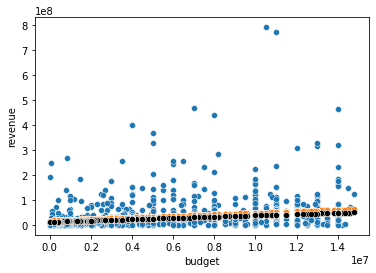

In [40]:
# Create a LinearRegression obeject.
model_31 = LinearRegression()
# Create some empty lists to store values.
coef = []
intercept = []
MSE = []
# Create a loop.
times = 0
while (times <= 100):
    # Seperate the dataset to training set and test set.
    train, test = train_test_split(data1)
    # Fit the dataset to the model.
    model_31 = model_31.fit(train["budget"].to_numpy().reshape(-1, 1), train["revenue"].to_numpy())
    # Store the value of slope (coefficient) in each loop.
    coef.append(model_31.coef_[0])
    # Store the value of intercept in the model of each loop.
    intercept.append(model_31.intercept_)
    # Calculate predicted values by the values of budget for each movie.
    predictions = model_31.predict(test["budget"].to_numpy().reshape(-1, 1))
    # Store the value of mean square value in the model of each loop.
    MSE.append(np.mean((test["revenue"] - predictions) ** 2))
    times = times + 1
# Use the average of the value of slope (coefficient) as the slope of the fianl model.
model_31.coef_ = np.array([np.mean(coef)])
# Use the average of the value of intercept as the intercept of the fianl model.
model_31.intercept_ = np.mean(intercept)
# Print the final linear regression model.
print("The final linear model is: Revenue = " + str(model_31.coef_[0]) + " * Budget + " + str(model_31.intercept_))
# Calculate the average of each linear regression model's MSE in the loop.
MSE_average = np.mean(MSE)
# Print out the average.
data1["predictions"] = model_31.predict(data1["budget"].to_numpy().reshape(-1, 1))
print("Average MSE:", MSE_average)
print("Average RMSE:", MSE_average ** 0.5 / 1000000, 'million')
model1mse = (data1['revenue'] - (data1["budget"] * 2.5666456407290505 + 12245913.01169521)) ** 2
print("Model 1 RMSE:", np.mean(model1mse) ** 0.5 / 1000000, 'million')
sns.scatterplot(data1["budget"], data1["revenue"])
sns.scatterplot(data1["budget"], data1["predictions"])
sns.scatterplot(data1["budget"], data1["budget"] * 2.5666456407290505 + 12245913.01169521, color='Black')

The final linear model is: Revenue = 2.380045859416622 * Budget + 12344998.210619027
Average MSE: 1.4633027315417098e+16
Average RMSE: 120.96705053615675 million
Model 1 RMSE: 119.67720459015753 million


<ipython-input-41-da807a79bab6>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data2["predictions"] = model_32.predict(data2["budget"].to_numpy().reshape(-1, 1))
/Users/zhezhou/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/zhezhou/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments wi

<AxesSubplot:xlabel='budget', ylabel='revenue'>

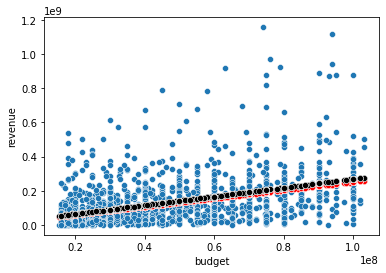

In [41]:
# Create a LinearRegression obeject.
model_32 = LinearRegression()
# Create some empty lists to store values.
coef = []
intercept = []
MSE = []
# Create a loop.
times = 0
while (times <= 100):
    # Seperate the dataset to training set and test set.
    train, test = train_test_split(data2)
    # Fit the dataset to the model.
    model_32 = model_32.fit(train["budget"].to_numpy().reshape(-1, 1), train["revenue"].to_numpy())
    # Store the value of slope (coefficient) in each loop.
    coef.append(model_32.coef_[0])
    # Store the value of intercept in the model of each loop.
    intercept.append(model_32.intercept_)
    # Calculate predicted values by the values of budget for each movie.
    predictions = model_32.predict(test["budget"].to_numpy().reshape(-1, 1))
    # Store the value of mean square value in the model of each loop.
    MSE.append(np.mean((test["revenue"] - predictions) ** 2))
    times = times + 1
# Use the average of the value of slope (coefficient) as the slope of the fianl model.
model_32.coef_ = np.array([np.mean(coef)])
# Use the average of the value of intercept as the intercept of the fianl model.
model_32.intercept_ = np.mean(intercept)
# Print the final linear regression model.
print("The final linear model is: Revenue = " + str(model_32.coef_[0]) + " * Budget + " + str(model_32.intercept_))
# Calculate the average of each linear regression model's MSE in the loop.
MSE_average = np.mean(MSE)
# Print out the average.
data2["predictions"] = model_32.predict(data2["budget"].to_numpy().reshape(-1, 1))
print("Average MSE:", MSE_average)
print("Average RMSE:", MSE_average ** 0.5 / 1000000, 'million')
model1mse = (data2['revenue'] - (data2["budget"] * 2.5666456407290505 + 12245913.01169521)) ** 2
print("Model 1 RMSE:", np.mean(model1mse) ** 0.5 / 1000000, 'million')
sns.scatterplot(data2["budget"], data2["revenue"])
sns.scatterplot(data2["budget"], data2["predictions"], color='Red')
sns.scatterplot(data2["budget"], data2["budget"] * 2.5666456407290505 + 12245913.01169521, color='Black')

The final linear model is: Revenue = 3.9119308965426813 * Budget + -120547765.25442715
Average MSE: 8.642215699443627e+16
Average RMSE: 293.9764565308526 million
Model 1 RMSE: 312.82331489501627 million


<ipython-input-42-94de11f952c7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data3["predictions"] = model_33.predict(data3["budget"].to_numpy().reshape(-1, 1))
/Users/zhezhou/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/zhezhou/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments wi

<AxesSubplot:xlabel='budget', ylabel='revenue'>

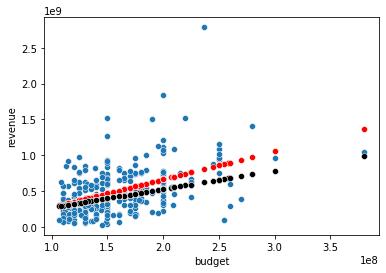

In [42]:
# Create a LinearRegression obeject.
model_33 = LinearRegression()
# Create some empty lists to store values.
coef = []
intercept = []
MSE = []
# Create a loop.
times = 0
while (times <= 100):
    # Seperate the dataset to training set and test set.
    train, test = train_test_split(data3)
    # Fit the dataset to the model.
    model_33 = model_33.fit(train["budget"].to_numpy().reshape(-1, 1), train["revenue"].to_numpy())
    # Store the value of slope (coefficient) in each loop.
    coef.append(model_33.coef_[0])
    # Store the value of intercept in the model of each loop.
    intercept.append(model_33.intercept_)
    # Calculate predicted values by the values of budget for each movie.
    predictions = model_33.predict(test["budget"].to_numpy().reshape(-1, 1))
    # Store the value of mean square value in the model of each loop.
    MSE.append(np.mean((test["revenue"] - predictions) ** 2))
    times = times + 1
# Use the average of the value of slope (coefficient) as the slope of the fianl model.
model_33.coef_ = np.array([np.mean(coef)])
# Use the average of the value of intercept as the intercept of the fianl model.
model_33.intercept_ = np.mean(intercept)
# Print the final linear regression model.
print("The final linear model is: Revenue = " + str(model_33.coef_[0]) + " * Budget + " + str(model_33.intercept_))
# Calculate the average of each linear regression model's MSE in the loop.
MSE_average = np.mean(MSE)
# Print out the average.
data3["predictions"] = model_33.predict(data3["budget"].to_numpy().reshape(-1, 1))
print("Average MSE:", MSE_average)
print("Average RMSE:", MSE_average ** 0.5 / 1000000, 'million')
model1mse = (data3['revenue'] - (data3["budget"] * 2.5666456407290505 + 12245913.01169521)) ** 2
print("Model 1 RMSE:", np.mean(model1mse) ** 0.5 / 1000000, 'million')
sns.scatterplot(data3["budget"], data3["revenue"])
sns.scatterplot(data3["budget"], data3["predictions"], color = 'Red')
sns.scatterplot(data3["budget"], data3["budget"] * 2.5666456407290505 + 12245913.01169521, color='Black')
# The final linear model is: Revenue = 2.5666456407290505 * Budget + 12245913.01169521